In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
# from censai import PowerSpectrum
from censai import PhysicalModelv2
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 27,
#           'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.titlesize': 40
         }
pylab.rcParams.update(params)
# plt.style.use("science")

In [5]:
hf = h5py.File("/home/aadam/scratch/Censai/results/RIMSU128hstv4_augmented_009_RMSP0_TS8_F16_NLleaky_relu_TWuniform_KRWsqrt_211117182256_RIMSource128hstv3_control_001_A0_L2_FLM0.0_211108220845.h5", 'r')

In [6]:
hf.keys()

<KeysViewHDF5 ['SIE_test', 'lenses128hst_TNG_rau_200k_control_denoised_testset_validated', 'lenses128hst_TNG_rau_200k_control_denoised_validated_train', 'lenses128hst_TNG_rau_200k_control_denoised_validated_val']>

# Train set

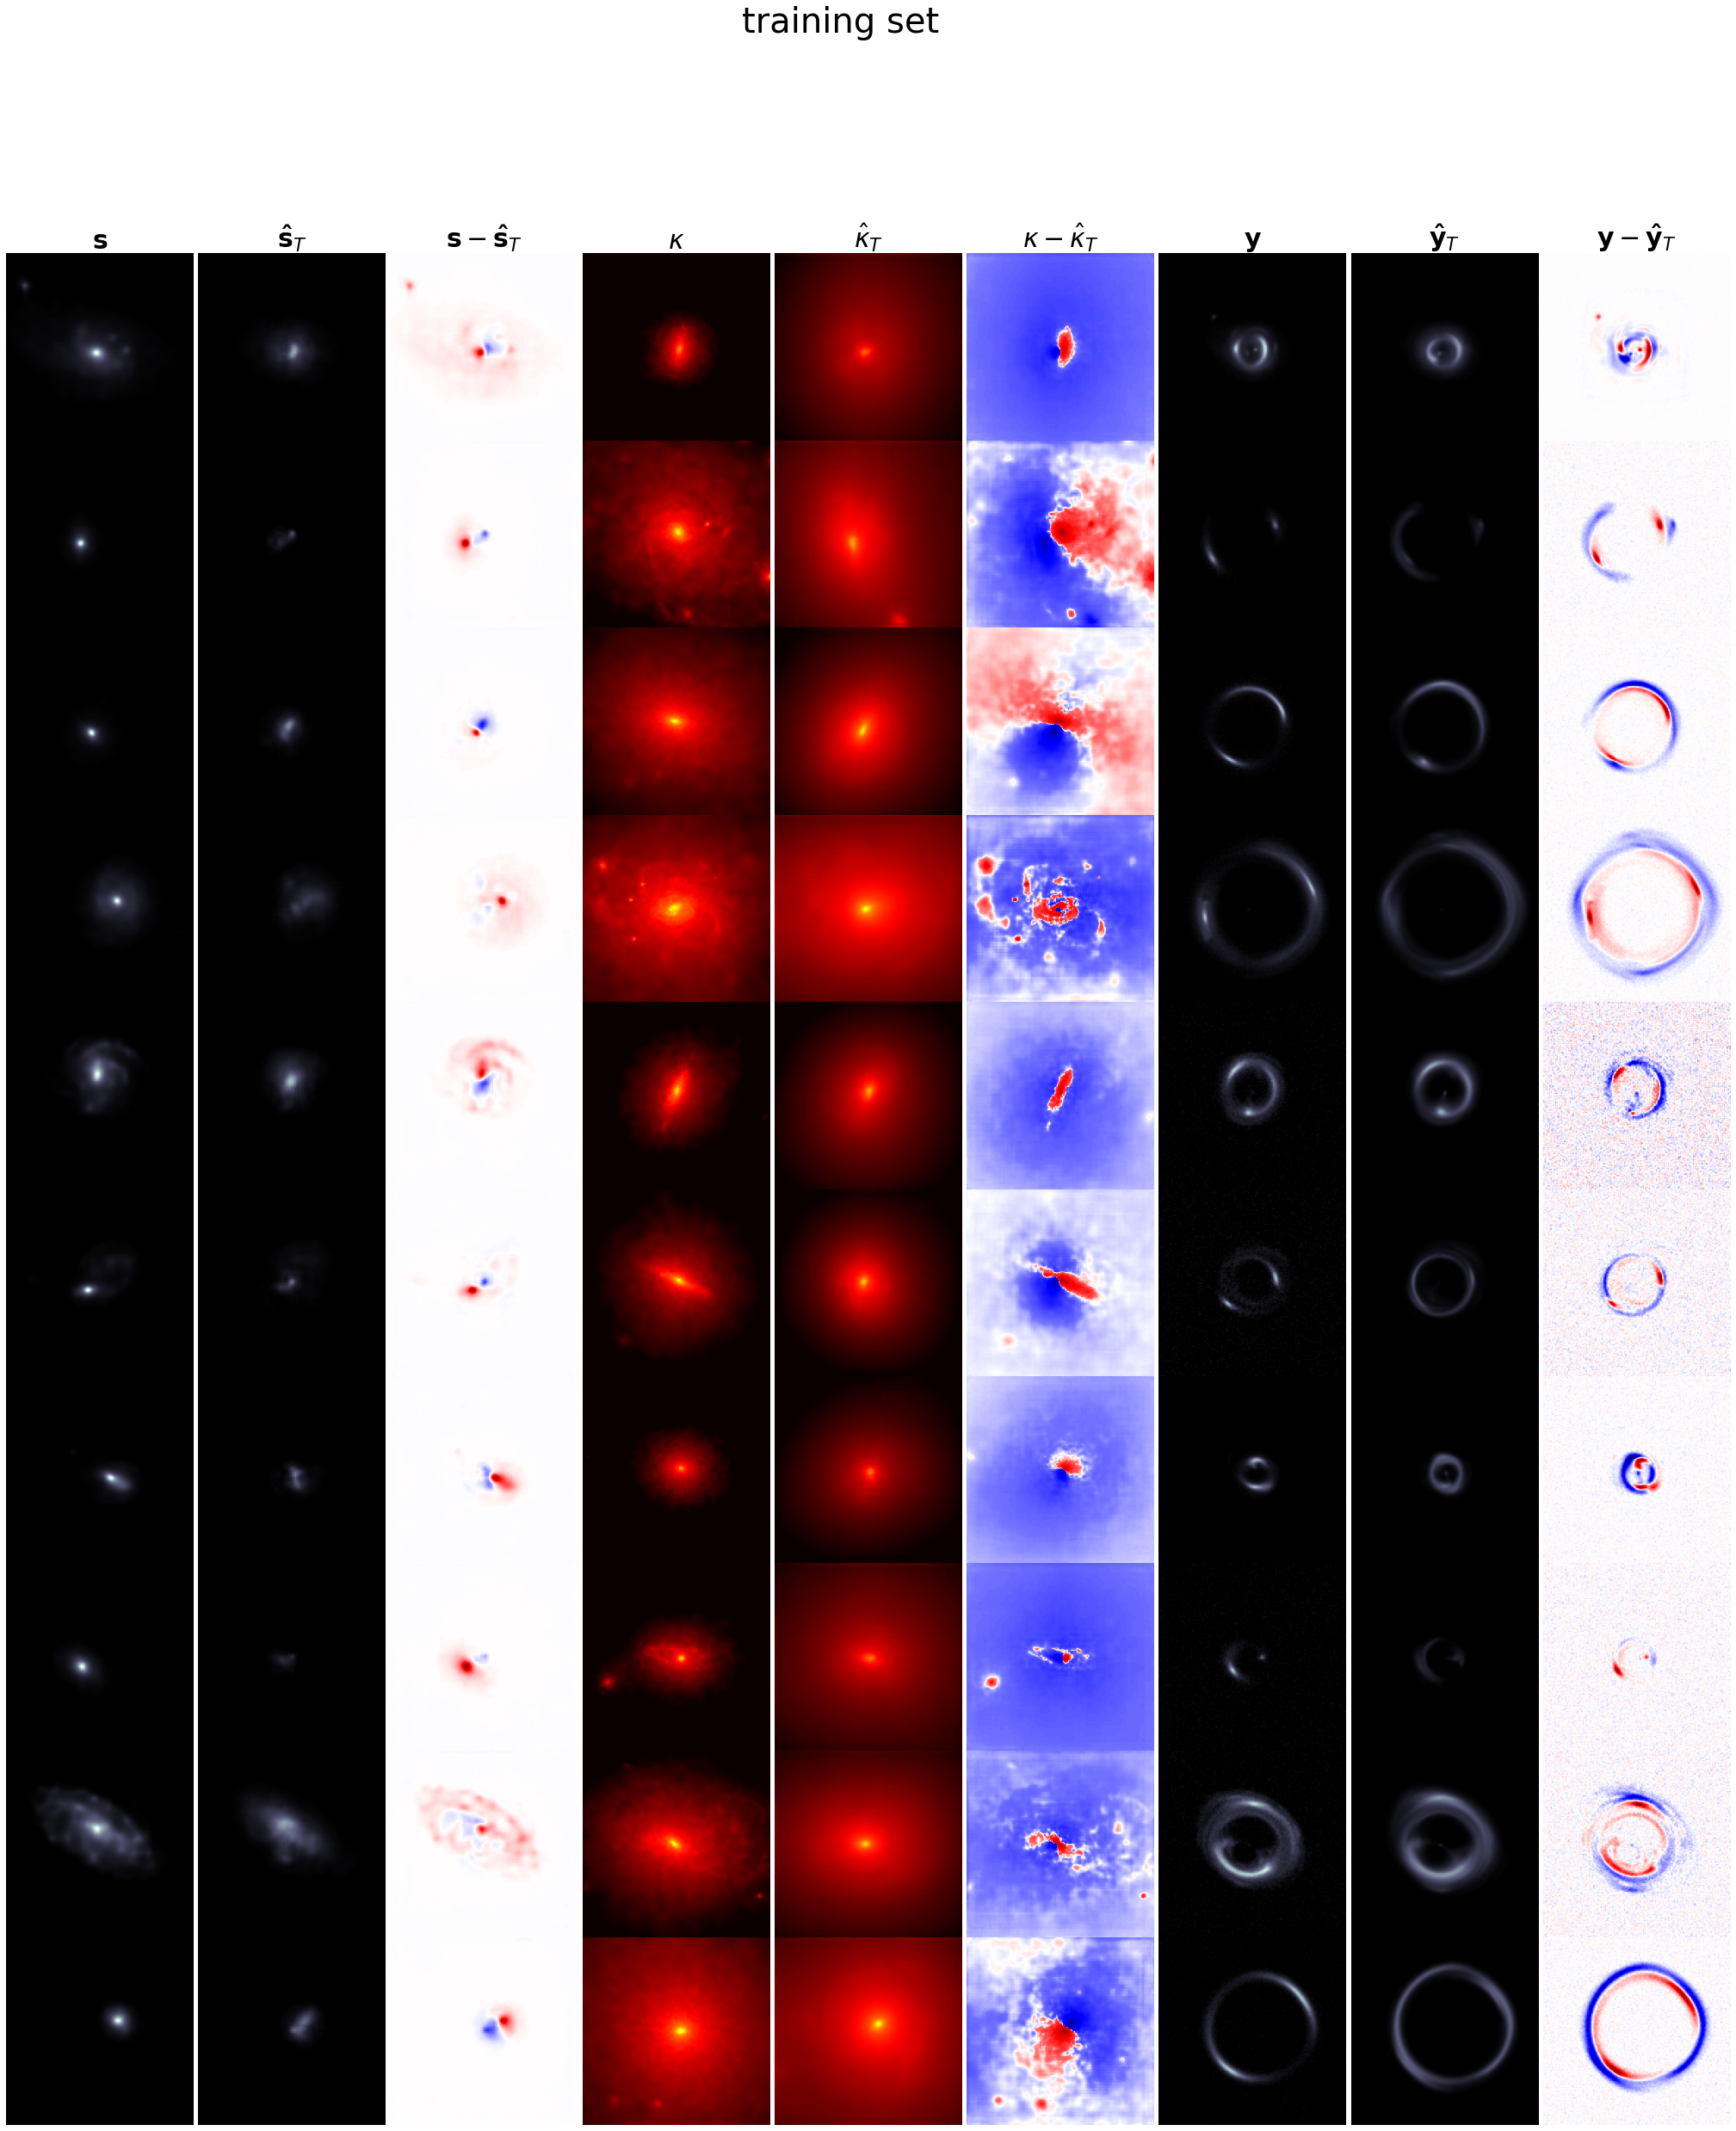

In [8]:
N = 10
start = 10
dataset = "lenses128hst_TNG_rau_200k_control_denoised_validated_train"


fig, axs = plt.subplots(N, 9, figsize=(36, 4 * N))

for i in range(N):
    k = i + start
    lens = np.array(hf[dataset][f"lens"]).squeeze()[k]
    source = np.array(hf[dataset][f"source"]).squeeze()[k]
    kappa = np.array(hf[dataset][f"kappa"]).squeeze()[k]
    lens_pred = np.array(hf[dataset][f"lens_pred"]).squeeze()[k]
    source_pred = np.array(hf[dataset][f"source_pred"]).squeeze()[k][-1]
    kappa_pred = np.array(hf[dataset][f"kappa_pred"]).squeeze()[k][-1]
    

    axs[i, 0].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 1].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(kappa - kappa_pred, cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 6].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 7].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(lens - lens_pred, cmap="seismic", norm=CenteredNorm(), origin="lower")
    
for i in range(N):
    for j in range(9):
        axs[i, j].axis("off")


# axs[0, 0].set_title("Source")
# axs[0, 1].set_title("Source prédite")
# axs[0, 2].set_title("Différence")
# axs[0, 3].set_title("$\kappa$")
# axs[0, 4].set_title("$\hat{\kappa}_T$")
# axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"../results/rim_pred{start:d}.png")
fig.suptitle("training set")
axs[0, 0].set_title(r"$\mathbf{s}$")
axs[0, 1].set_title(r"$\mathbf{\hat{s}}_T$")
axs[0, 2].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}_T$")
axs[0, 3].set_title("$\kappa$")
axs[0, 4].set_title("$\hat{\kappa}_T$")
axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 6].set_title("$\mathbf{y}$")
axs[0, 7].set_title("$\mathbf{\hat{y}}_T$")
axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
plt.subplots_adjust(wspace=0, hspace=0)


(-0.5, 127.5, -0.5, 127.5)

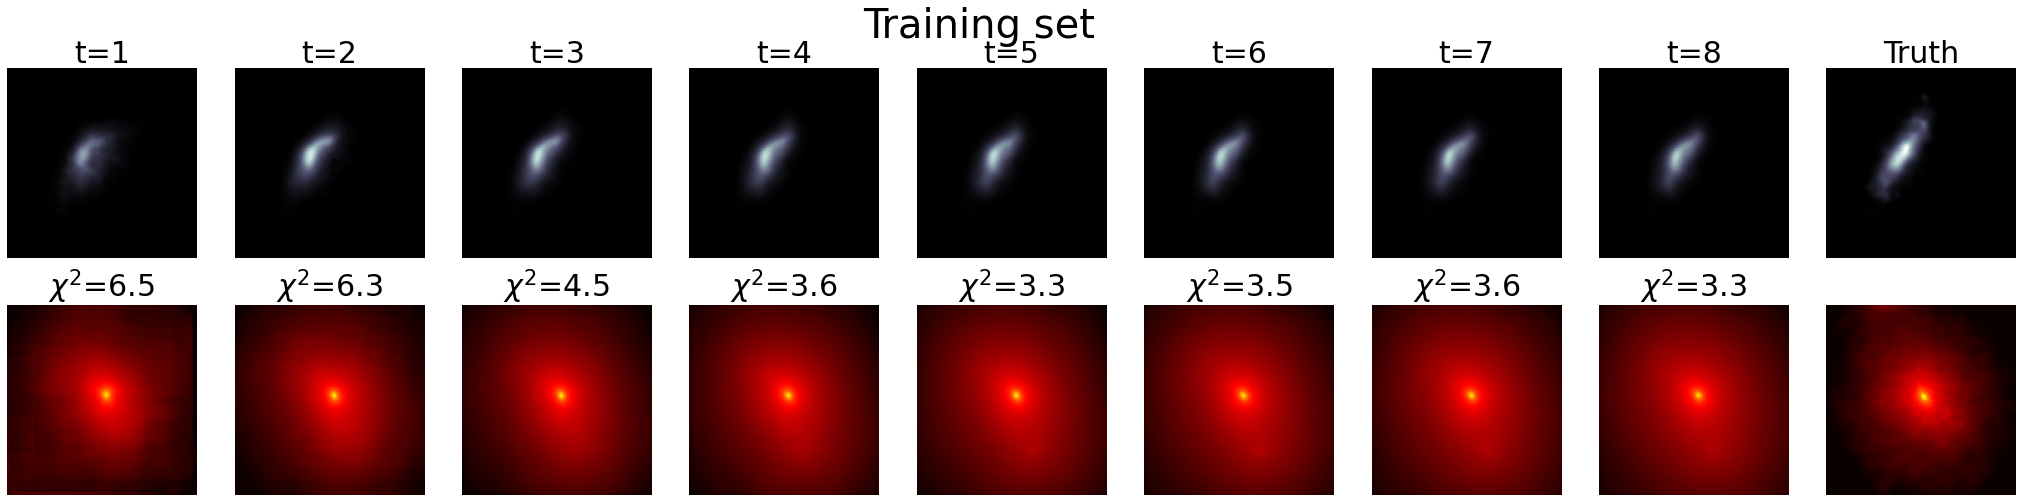

In [74]:
k = 63
fig, axs = plt.subplots(2, 9, figsize=(36, 8))
fig.suptitle("Training set")
source = np.array(hf[dataset][f"source"]).squeeze()[k]
kappa = np.array(hf[dataset][f"kappa"]).squeeze()[k]
source_pred = np.array(hf[dataset][f"source_pred"]).squeeze()[k]
kappa_pred = np.array(hf[dataset][f"kappa_pred"]).squeeze()[k]
cs = np.array(hf[dataset][f"chi_squared"][k])
cs[:-1] = cs[:-1]/128**2 # take mean over pixel, only done for last chi squared
kappa_pred[0] = 10**kappa_pred[0] # quick bug fix
for i in range(8):
    axs[0, i].imshow(source_pred[i], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"t={i+1}")
    axs[1, i].imshow(kappa_pred[i], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[1, i].axis("off")
    axs[1, i].set_title(fr"$\chi^ 2$={cs[i]:.1f}")
axs[0, -1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
axs[0, -1].axis("off")
axs[0, -1].set_title(f"Truth")
axs[1, -1].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[1, -1].axis("off")

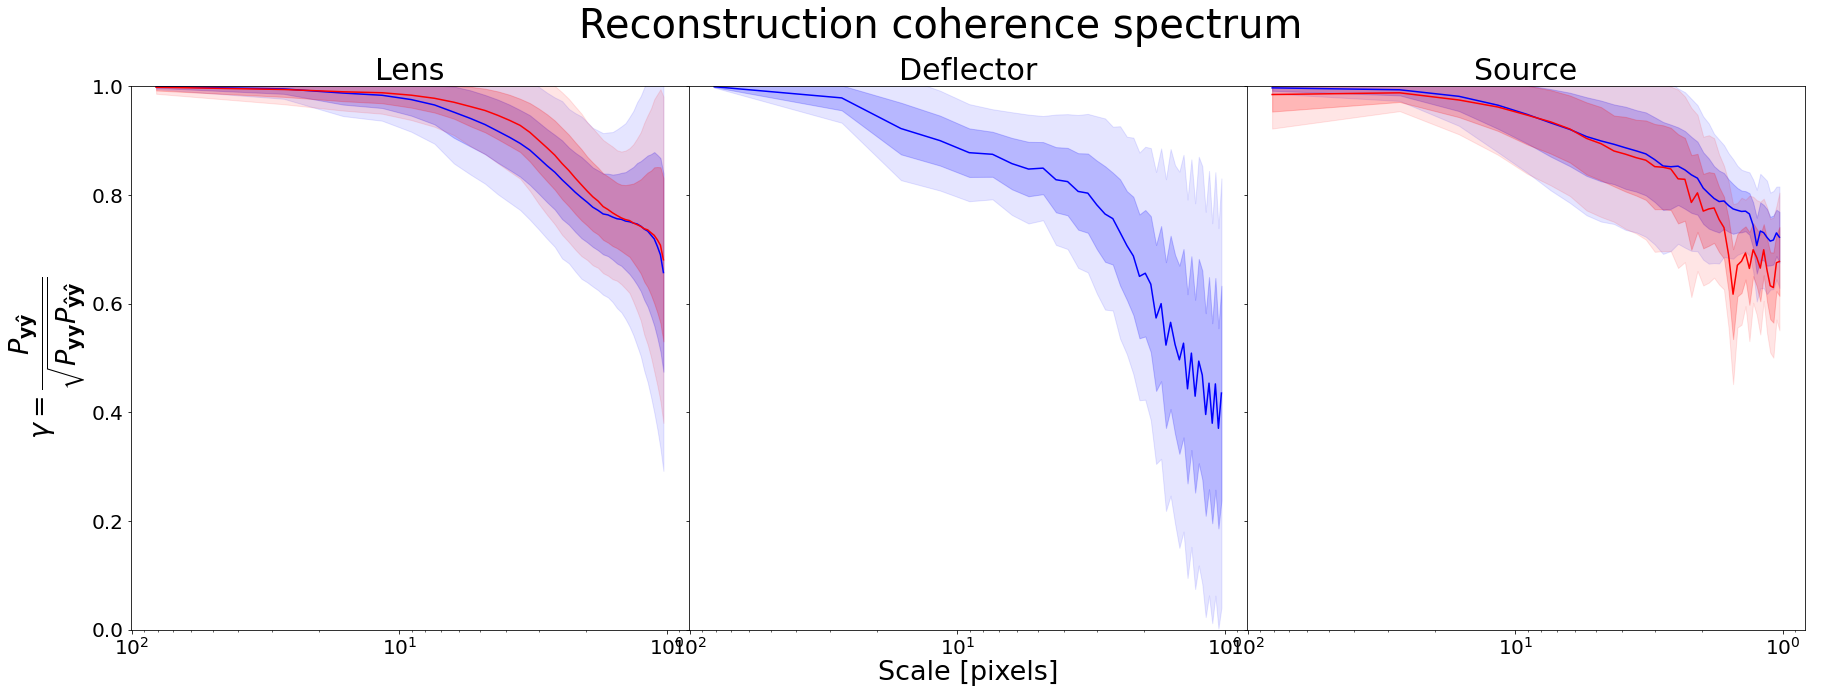

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
color = "b"
color2 = "r"

# lens
r = np.array(hf[dataset]["lens_coherence_spectrum"])
f = np.array(hf[dataset]["lens_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2


ax1.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax1.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax1.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")

# lens 2
r = np.array(hf[dataset]["lens_coherence_spectrum2"])
r_mean = r.mean(axis=0)
r_std = r.std(axis=0)

ax1.plot(lam, r_mean, "-", color=color2, label=r"$\bar{\gamma}$")
ax1.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color2, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax1.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
# ax1.set_xlabel(r"$\dfrac{1}{2}\lambda$ [arcsec]")
ax1.invert_xaxis()
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
# plt.xlim(128, 3)
# ax1.legend(loc="lower left")
ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{y}\mathbf{\hat{y}}}}{\sqrt{P_{\mathbf{y}\mathbf{y}} P_{\mathbf{\hat{y}}\mathbf{\hat{y}}}}}$")
ax1.set_title("Lens")


# kappa
r = np.array(hf[dataset]["kappa_coherence_spectrum"])
f = np.array(hf[dataset]["kappa_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2



ax2.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax2.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax2.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax2.invert_xaxis()
ax2.set_xscale("log")
ax2.set_ylim(0, 1)
ax2.set_title("Deflector")
# plt.xlim(128, 3)
# ax2.legend(loc="lower left")


# source
r = np.array(hf[dataset]["source_coherence_spectrum"])
f = np.array(hf[dataset]["source_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2

ax3.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax3.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax3.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")

# source 2
r = np.array(hf[dataset]["source_coherence_spectrum2"])
r_mean = r.mean(axis=0)
r_std = r.std(axis=0)

ax3.plot(lam, r_mean, "-", color=color2, label=r"$\bar{\gamma}$")
ax3.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color2, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax3.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax3.invert_xaxis()
ax3.set_xscale("log")
ax3.set_ylim(0, 1)
ax3.set_title("Source")
# plt.xlim(128, 3)
# ax3.legend(loc="lower left")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Scale [pixels]")

plt.subplots_adjust(wspace=0, hspace=0);
fig.suptitle("Reconstruction coherence spectrum", y=0.99);


# Validation set

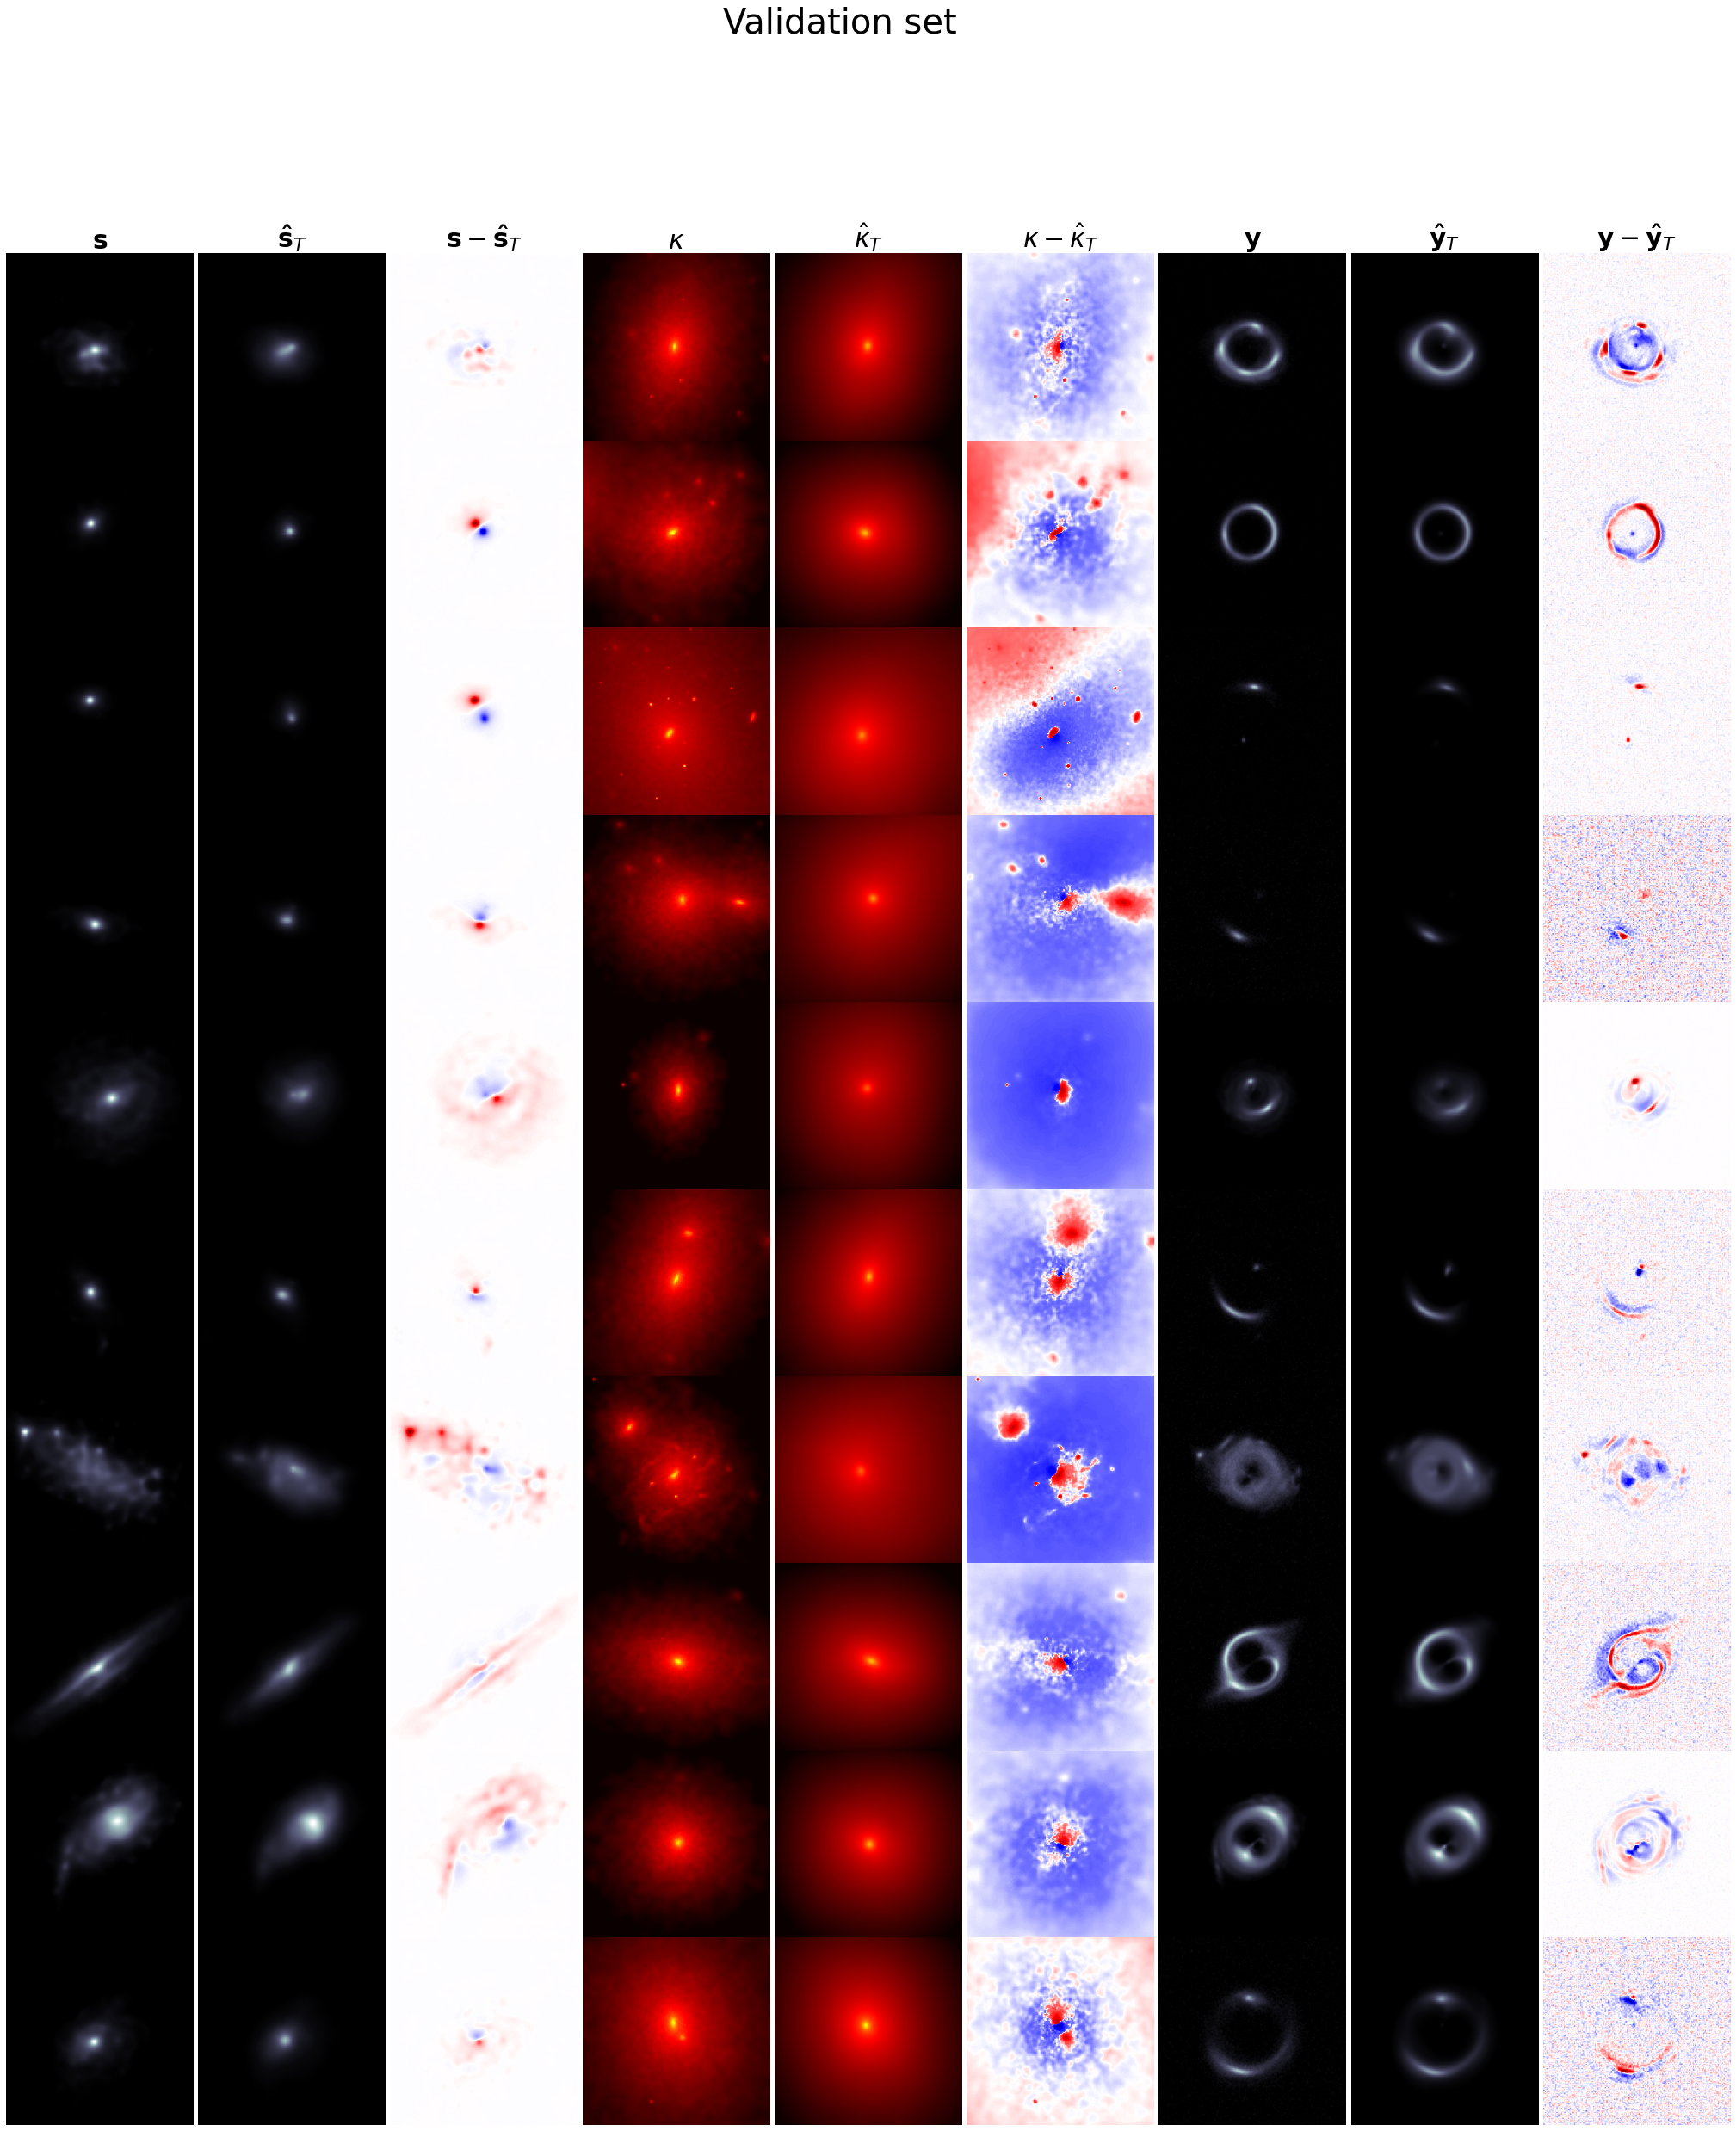

In [88]:
N = 10
start = 90
dataset = "lenses128hst_TNG_rau_200k_control_denoised_validated_val"


fig, axs = plt.subplots(N, 9, figsize=(36, 4 * N))

for i in range(N):
    k = i + start
    lens = np.array(hf[dataset][f"lens"]).squeeze()[k]
    source = np.array(hf[dataset][f"source"]).squeeze()[k]
    kappa = np.array(hf[dataset][f"kappa"]).squeeze()[k]
    lens_pred = np.array(hf[dataset][f"lens_pred"]).squeeze()[k]
    source_pred = np.array(hf[dataset][f"source_pred"]).squeeze()[k][-1]
    kappa_pred = np.array(hf[dataset][f"kappa_pred"]).squeeze()[k][-1]
    

    axs[i, 0].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 1].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(kappa - kappa_pred, cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 6].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 7].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(lens - lens_pred, cmap="seismic", norm=CenteredNorm(), origin="lower")
    
for i in range(N):
    for j in range(9):
        axs[i, j].axis("off")


# axs[0, 0].set_title("Source")
# axs[0, 1].set_title("Source prédite")
# axs[0, 2].set_title("Différence")
# axs[0, 3].set_title("$\kappa$")
# axs[0, 4].set_title("$\hat{\kappa}_T$")
# axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"../results/rim_pred{start:d}.png")

fig.suptitle("Validation set")
axs[0, 0].set_title(r"$\mathbf{s}$")
axs[0, 1].set_title(r"$\mathbf{\hat{s}}_T$")
axs[0, 2].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}_T$")
axs[0, 3].set_title("$\kappa$")
axs[0, 4].set_title("$\hat{\kappa}_T$")
axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 6].set_title("$\mathbf{y}$")
axs[0, 7].set_title("$\mathbf{\hat{y}}_T$")
axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
plt.subplots_adjust(wspace=0, hspace=0)


(-0.5, 127.5, -0.5, 127.5)

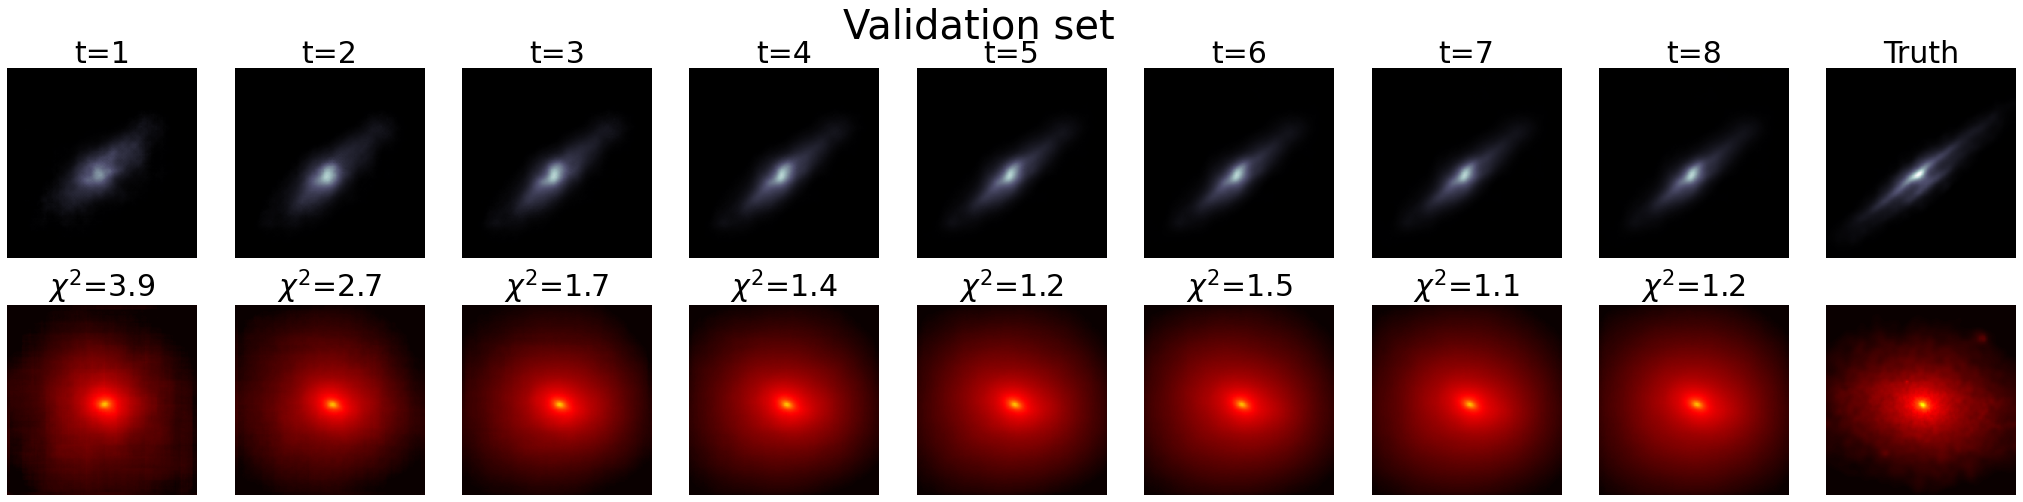

In [89]:
k = 97
fig, axs = plt.subplots(2, 9, figsize=(36, 8))
source = np.array(hf[dataset][f"source"]).squeeze()[k]
kappa = np.array(hf[dataset][f"kappa"]).squeeze()[k]
source_pred = np.array(hf[dataset][f"source_pred"]).squeeze()[k]
kappa_pred = np.array(hf[dataset][f"kappa_pred"]).squeeze()[k]

cs = np.array(hf[dataset][f"chi_squared"][k])
cs[:-1] = cs[:-1]/128**2 # take mean over pixel for every step except last
kappa_pred[0] = 10**kappa_pred[0] # quick bug fix
for i in range(8):
    axs[0, i].imshow(source_pred[i], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"t={i+1}")
    axs[1, i].imshow(kappa_pred[i], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[1, i].axis("off")
    axs[1, i].set_title(fr"$\chi^ 2$={cs[i]:.1f}")
    
fig.suptitle("Validation set")
axs[0, -1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
axs[0, -1].axis("off")
axs[0, -1].set_title(f"Truth")
axs[1, -1].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[1, -1].axis("off")

In [85]:
((source_pred - source)**2).mean(axis=(1, 2))

array([0.00070318, 0.00065931, 0.00073074, 0.00081619, 0.00088637,
       0.00094533, 0.00098925, 0.00102202], dtype=float32)

In [86]:
((kappa_pred - kappa)**2).mean(axis=(1, 2))

array([0.12869336, 0.12094872, 0.12233438, 0.12467327, 0.12583284,
       0.1268778 , 0.12755385, 0.12803097], dtype=float32)

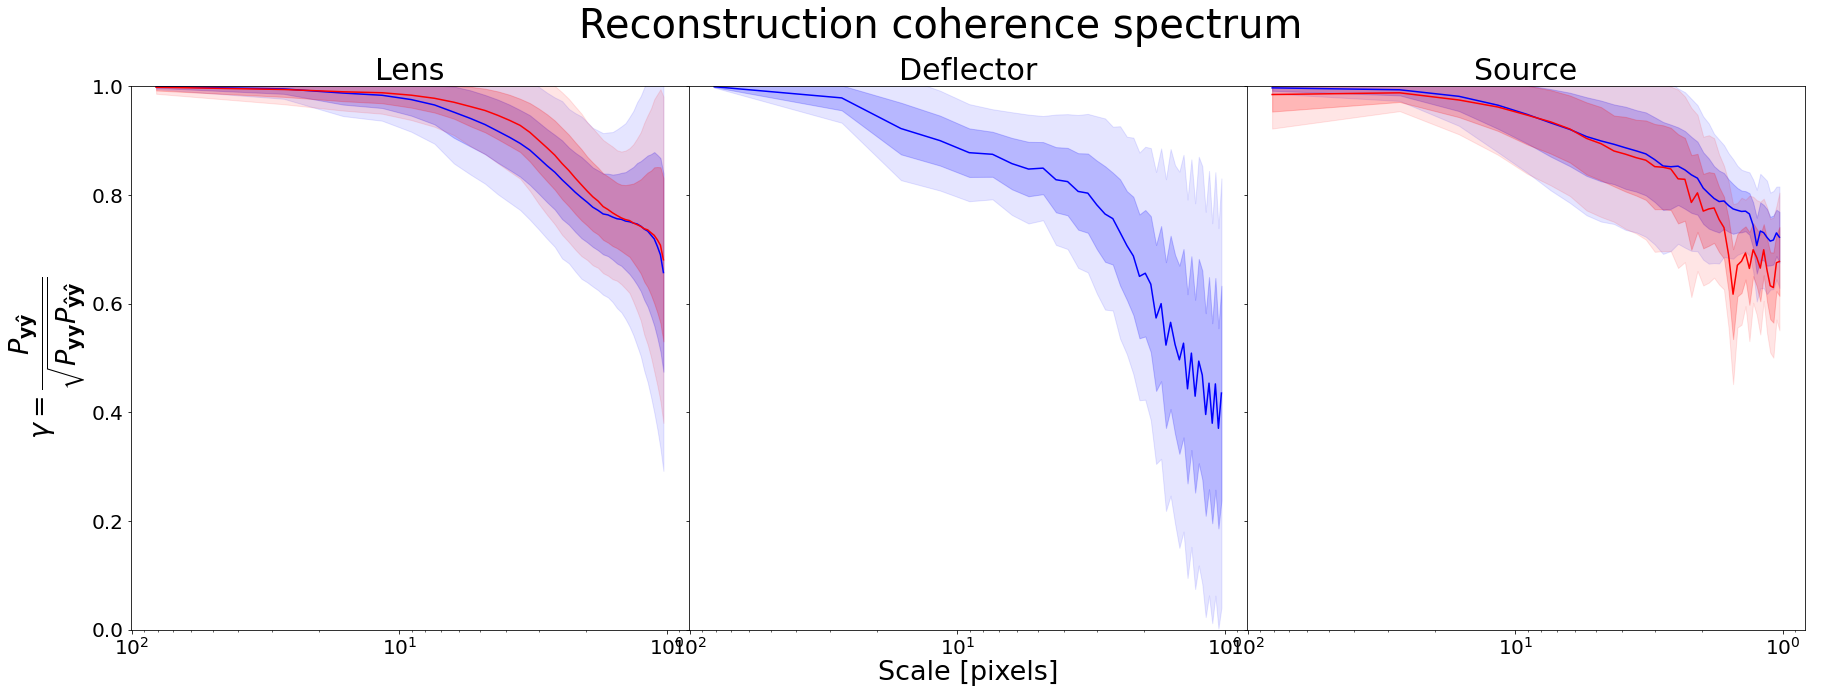

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
color = "b"
color2 = "r"

# lens
r = np.array(hf[dataset]["lens_coherence_spectrum"])
f = np.array(hf[dataset]["lens_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2


ax1.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax1.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax1.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")

# lens 2
r = np.array(hf[dataset]["lens_coherence_spectrum2"])
r_mean = r.mean(axis=0)
r_std = r.std(axis=0)

ax1.plot(lam, r_mean, "-", color=color2, label=r"$\bar{\gamma}$")
ax1.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color2, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax1.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
# ax1.set_xlabel(r"$\dfrac{1}{2}\lambda$ [arcsec]")
ax1.invert_xaxis()
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
# plt.xlim(128, 3)
# ax1.legend(loc="lower left")
ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{y}\mathbf{\hat{y}}}}{\sqrt{P_{\mathbf{y}\mathbf{y}} P_{\mathbf{\hat{y}}\mathbf{\hat{y}}}}}$")
ax1.set_title("Lens")


# kappa
r = np.array(hf[dataset]["kappa_coherence_spectrum"])
f = np.array(hf[dataset]["kappa_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2



ax2.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax2.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax2.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax2.invert_xaxis()
ax2.set_xscale("log")
ax2.set_ylim(0, 1)
ax2.set_title("Deflector")
# plt.xlim(128, 3)
# ax2.legend(loc="lower left")


# source
r = np.array(hf[dataset]["source_coherence_spectrum"])
f = np.array(hf[dataset]["source_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
lam = 1/f/2

ax3.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax3.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax3.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")

# source 2
r = np.array(hf[dataset]["source_coherence_spectrum2"])
r_mean = r.mean(axis=0)
r_std = r.std(axis=0)

ax3.plot(lam, r_mean, "-", color=color2, label=r"$\bar{\gamma}$")
ax3.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color2, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
ax3.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax3.invert_xaxis()
ax3.set_xscale("log")
ax3.set_ylim(0, 1)
ax3.set_title("Source")
# plt.xlim(128, 3)
# ax3.legend(loc="lower left")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Scale [pixels]")

plt.subplots_adjust(wspace=0, hspace=0);
fig.suptitle("Reconstruction coherence spectrum", y=0.99);
